<a href="https://colab.research.google.com/github/PurnamaRidzkyN/StoreSales-TimeSeriesForecasting/blob/main/Store_Sales_Time_Series_Forecasting2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'store-sales-time-series-forecasting:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F29781%2F2887556%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240708%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240708T082830Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2dcd481846d0afc9703ee4ffa0c8e870f8c842c13b162f8ef7654d42f8027cbef1c787d7b29873c994afdb0019a9febe2cf14f1fbbd503cf27bb091729cf869d45c7c3503d572918b772c42689a35341270e13816ffcb7d57f441014e85db33dc7571a45c4e116aa476c72169f1b4979ddc901c83287190204f587d9ac62b7c29b17ab44e0a8d8c262d8925d15c85f2ffd5913746e4e88536c0291d34f8c65c5aee2b688b7e295a31b226339797e1f77c1ff8dda2d07015cedd279dc4a152de0b59b352cd1b5202f0a2c2472e88ae186f6110fc500ba9978e8799b52df6b61cbda89504abb44baee8ec147b5296d22cbe261a33579a6044be185bc5f24c63b60'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [ ]:
df_train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv',index_col='date')
df_train.index= pd.to_datetime(df_train.index)

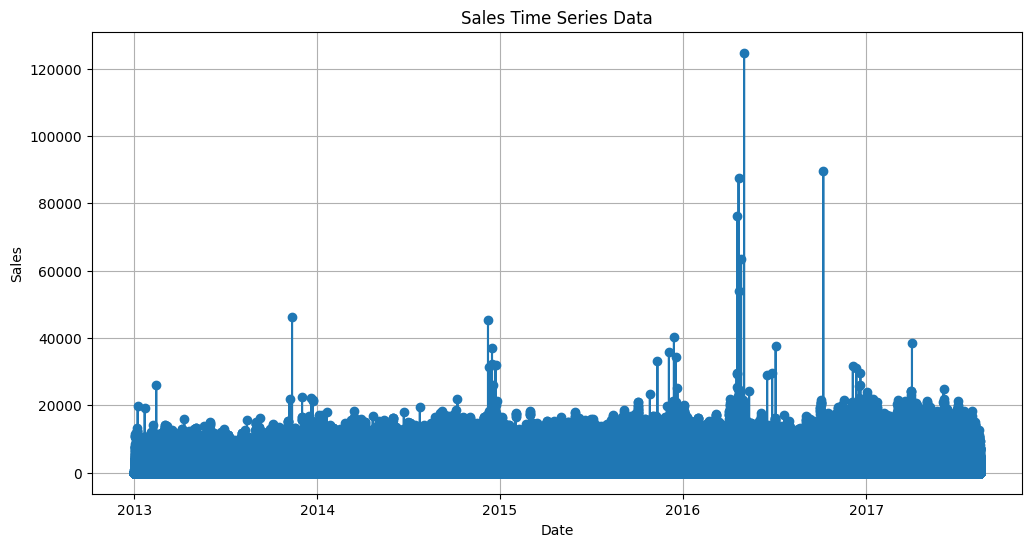

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train['sales'], marker='o', linestyle='-')
plt.title('Sales Time Series Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


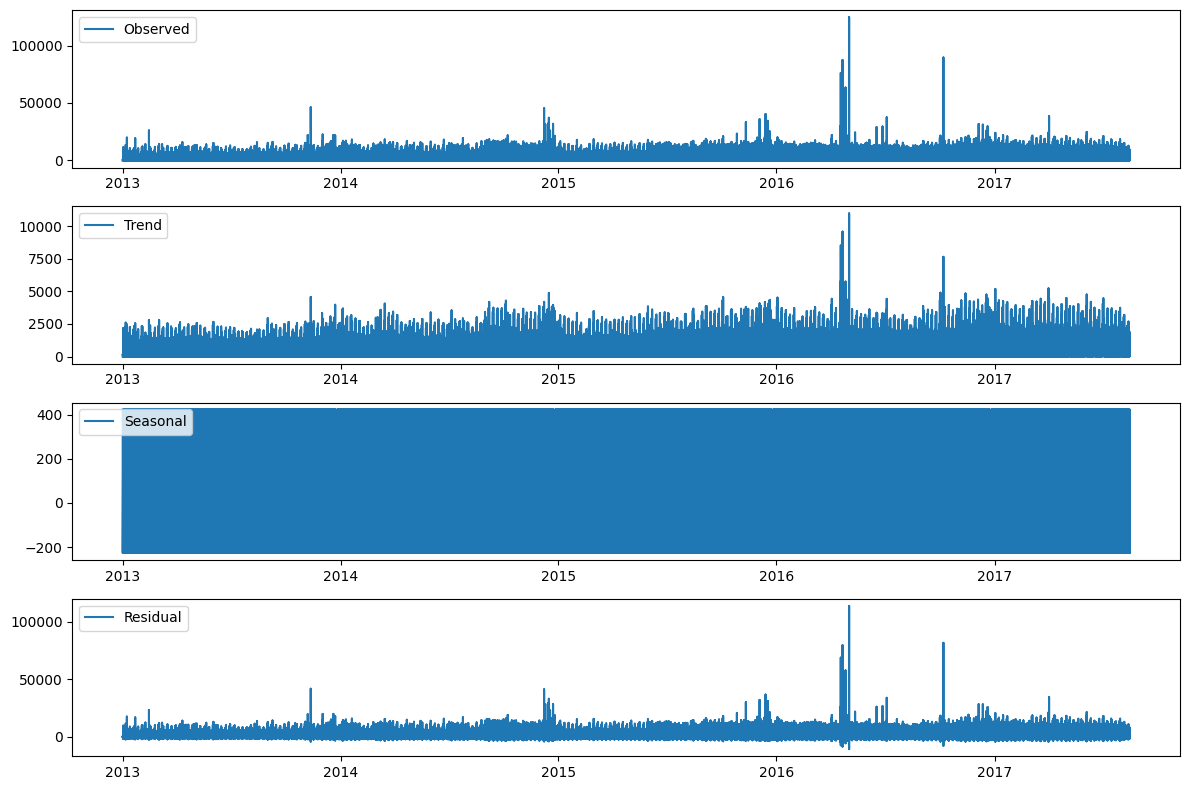

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Dekomposisi musiman
decomposition = seasonal_decompose(df_train['sales'], model='additive', period=12)  # misalnya period=12 untuk pola tahunan

# Plot hasil dekomposisi
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df_train.index, decomposition.observed, label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(df_train.index, decomposition.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(df_train.index, decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(df_train.index, decomposition.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


/tmp/ipykernel_33/964232032.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df_train['sales'].resample('M').sum()


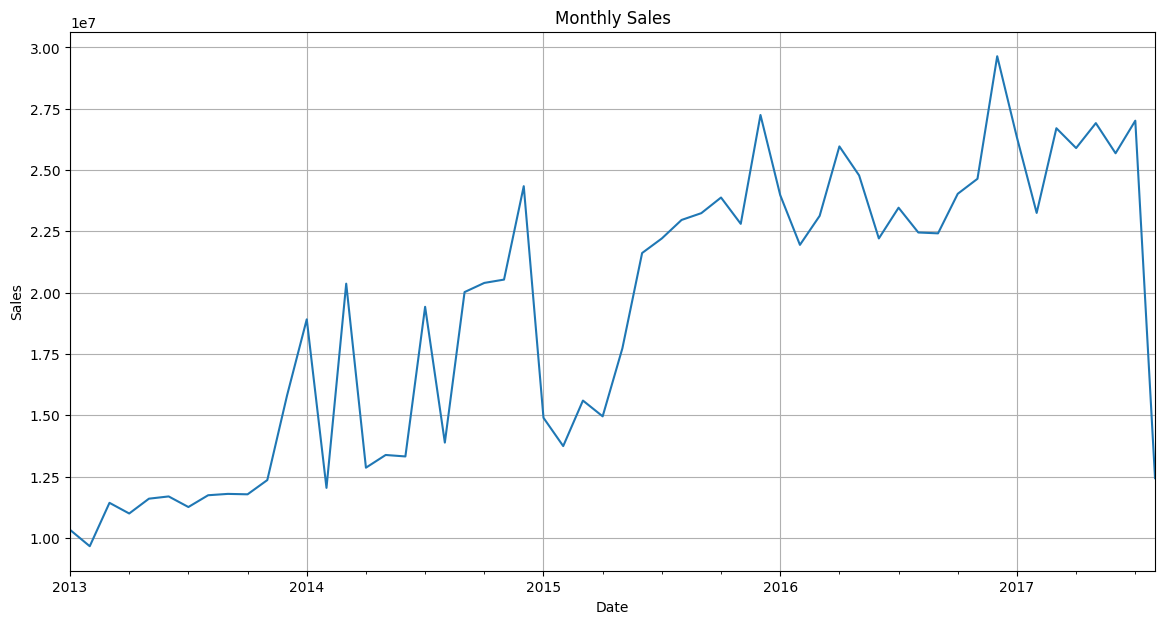

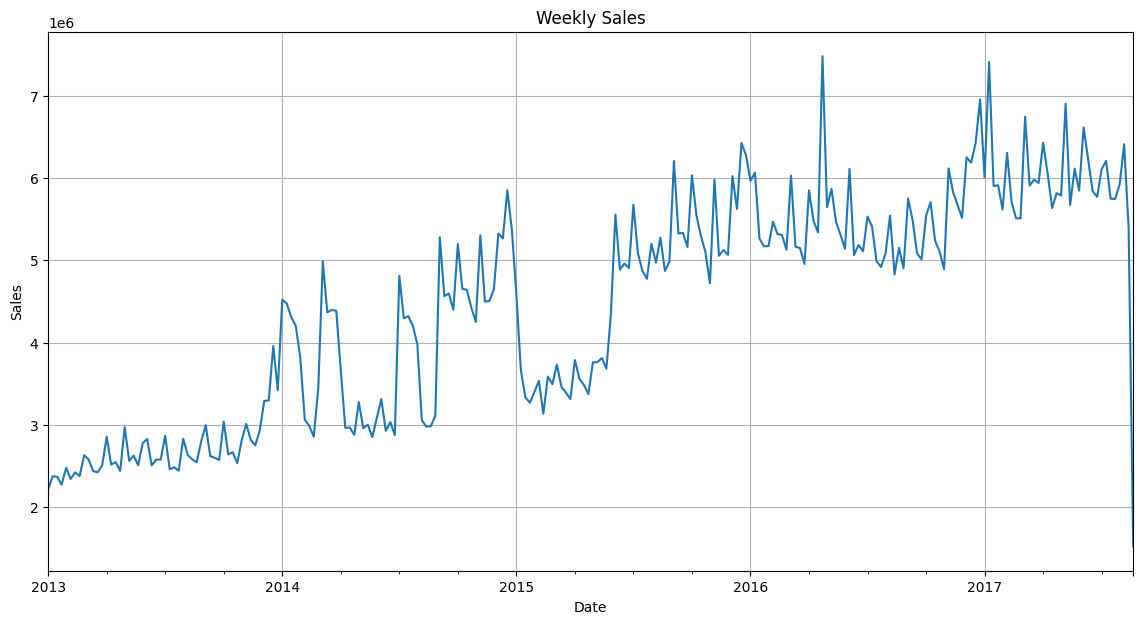

In [ ]:
# Aggregate data per month
monthly_data = df_train['sales'].resample('M').sum()

# Aggregate data per week
weekly_data = df_train['sales'].resample('W').sum()

# Plot data per month
plt.figure(figsize=(14, 7))
monthly_data.plot()
plt.title('Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# Plot data per week
plt.figure(figsize=(14, 7))
weekly_data.plot()
plt.title('Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

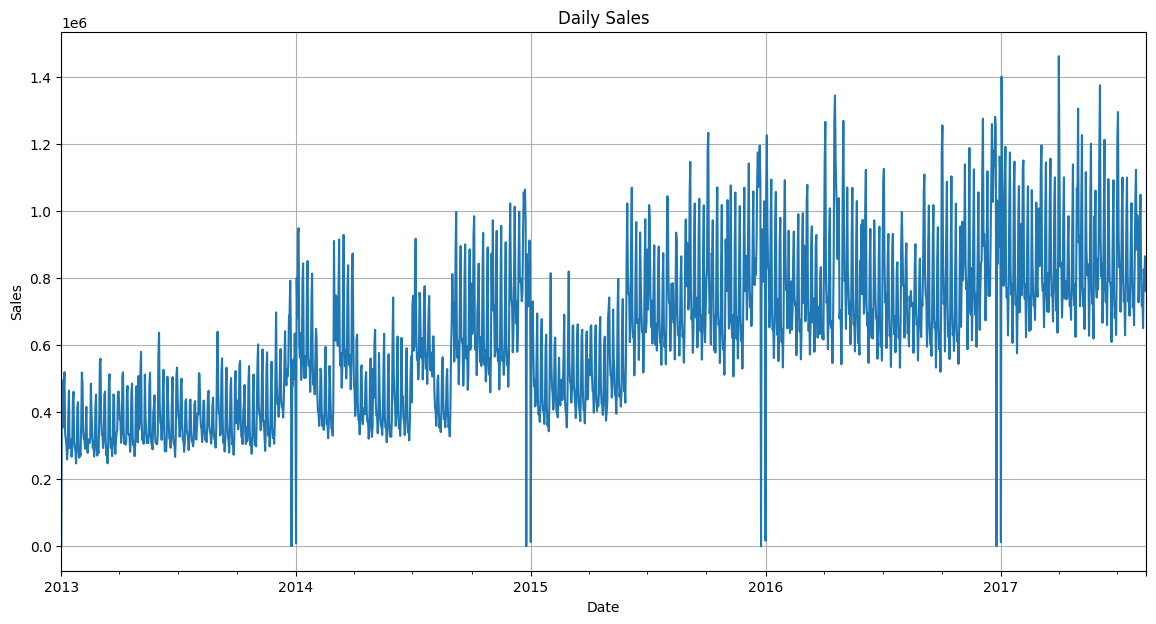

In [ ]:
daily_data = df_train['sales'].resample('D').sum()

# Plot data per day
plt.figure(figsize=(14, 7))
daily_data.plot()
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

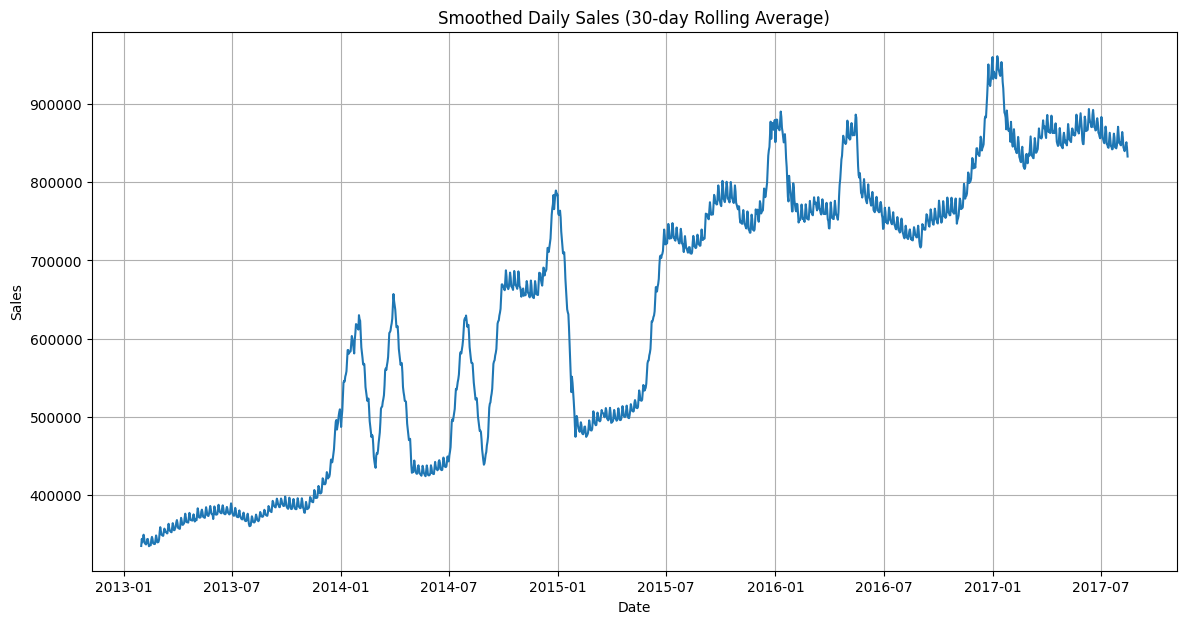

In [ ]:
daily_data_smoothed = daily_data.rolling(window=30).mean()

plt.figure(figsize=(14, 7))
plt.plot(daily_data_smoothed)
plt.title('Smoothed Daily Sales (30-day Rolling Average)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


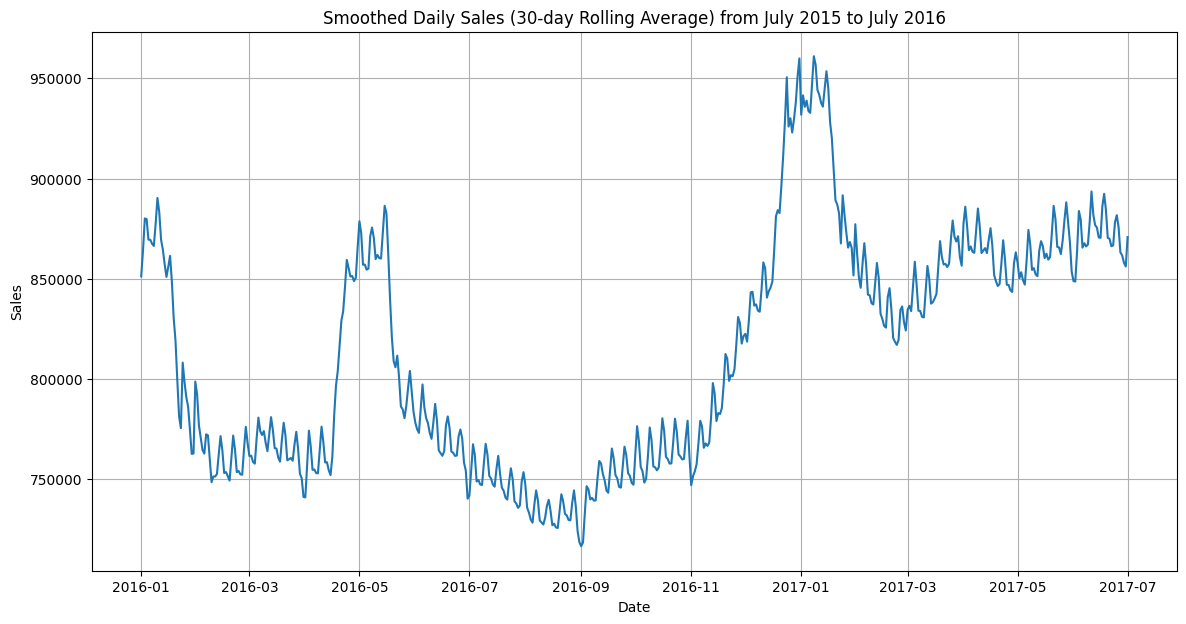

In [ ]:
# Filter data dari Juli 2015 hingga Juli 2016
start_date = '2016-01-01'
end_date = '2017-07-01'
filtered_data = daily_data_smoothed.loc[start_date:end_date]

# Plot data yang sudah difilter
plt.figure(figsize=(14, 7))
plt.plot(filtered_data)
plt.title('Smoothed Daily Sales (30-day Rolling Average) from July 2015 to July 2016')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

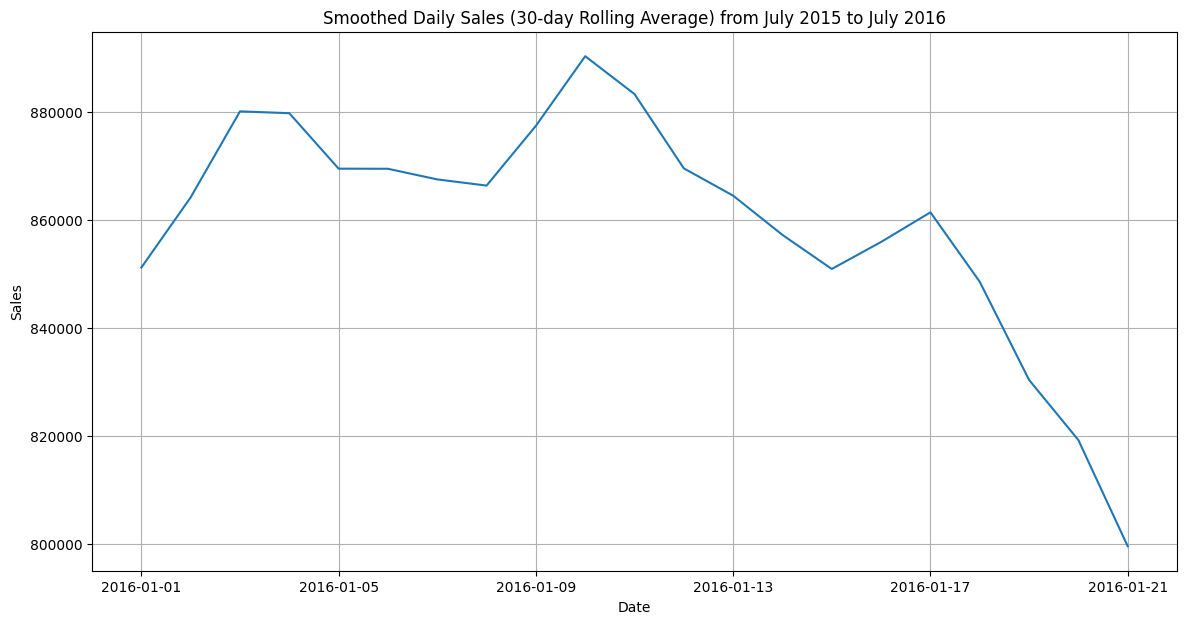

In [ ]:
# Filter data dari Juli 2015 hingga Juli 2016
start_date = '2016-01-01'
end_date = '2016-01-21'
filtered_data = daily_data_smoothed.loc[start_date:end_date]

# Plot data yang sudah difilter
plt.figure(figsize=(14, 7))
plt.plot(filtered_data)
plt.title('Smoothed Daily Sales (30-day Rolling Average) from July 2015 to July 2016')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

In [ ]:
start_date = '2015-07-01'
df_train = df_train[df_train.index >= start_date]

In [ ]:
df_train

,id,store_nbr,family,sales,onpromotion
date,,,,,
2015-07-01,1619838,1,AUTOMOTIVE,5.000,0
2015-07-01,1619839,1,BABY CARE,0.000,0
2015-07-01,1619840,1,BEAUTY,5.000,1
2015-07-01,1619841,1,BEVERAGES,2638.000,2
2015-07-01,1619842,1,BOOKS,0.000,0
...,...,...,...,...,...
2017-08-15,3000883,9,POULTRY,438.133,0
2017-08-15,3000884,9,PREPARED FOODS,154.553,1
2017-08-15,3000885,9,PRODUCE,2419.729,148


In [ ]:
df_holiday = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
df_holiday= df_holiday.loc[df_holiday['transferred'] == False]
df_stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')

In [ ]:
df_merged = pd.merge(df_train, df_stores, on='store_nbr', how='left')
start_id = df_train.index[0]

In [ ]:
df_train

,id,store_nbr,family,sales,onpromotion
date,,,,,
2015-07-01,1619838,1,AUTOMOTIVE,5.000,0
2015-07-01,1619839,1,BABY CARE,0.000,0
2015-07-01,1619840,1,BEAUTY,5.000,1
2015-07-01,1619841,1,BEVERAGES,2638.000,2
2015-07-01,1619842,1,BOOKS,0.000,0
...,...,...,...,...,...
2017-08-15,3000883,9,POULTRY,438.133,0
2017-08-15,3000884,9,PREPARED FOODS,154.553,1
2017-08-15,3000885,9,PRODUCE,2419.729,148


In [ ]:
df_merged

,id,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,1619838,1,AUTOMOTIVE,5.000,0,Quito,Pichincha,D,13
1,1619839,1,BABY CARE,0.000,0,Quito,Pichincha,D,13
2,1619840,1,BEAUTY,5.000,1,Quito,Pichincha,D,13
3,1619841,1,BEVERAGES,2638.000,2,Quito,Pichincha,D,13
4,1619842,1,BOOKS,0.000,0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...
1381045,3000883,9,POULTRY,438.133,0,Quito,Pichincha,B,6
1381046,3000884,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6
1381047,3000885,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6
1381048,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6


In [ ]:
df_holiday['date'] = pd.to_datetime(df_holiday['date'])

In [ ]:
kolom_duplikat = 'date'


df_holiday = df_holiday[df_holiday['transferred'] == False]
df_holiday = df_holiday.drop_duplicates(subset=kolom_duplikat, keep='first')


In [ ]:
df_holiday.info()
df_merged['date'] = df_train.index

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         300 non-null    datetime64[ns]
 1   type         300 non-null    object        
 2   locale       300 non-null    object        
 3   locale_name  300 non-null    object        
 4   description  300 non-null    object        
 5   transferred  300 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.4+ KB


In [ ]:

end_date = '2017-08-15'
df_holiday_filtered = df_holiday[(df_holiday['date'] >= start_date) & (df_holiday['date'] <= end_date)]

df_merge= pd.merge(df_merged, df_holiday_filtered, on='date' ,how='left')

In [ ]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1381050 entries, 0 to 1381049
Data columns (total 15 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   id           1381050 non-null  int64         
 1   store_nbr    1381050 non-null  int64         
 2   family       1381050 non-null  object        
 3   sales        1381050 non-null  float64       
 4   onpromotion  1381050 non-null  int64         
 5   city         1381050 non-null  object        
 6   state        1381050 non-null  object        
 7   type_x       1381050 non-null  object        
 8   cluster      1381050 non-null  int64         
 9   date         1381050 non-null  datetime64[ns]
 10  type_y       217404 non-null   object        
 11  locale       217404 non-null   object        
 12  locale_name  217404 non-null   object        
 13  description  217404 non-null   object        
 14  transferred  217404 non-null   object        
dtypes: datetime64[n

In [ ]:
df_merge = df_merge.fillna(0)

In [ ]:
df_merge

,id,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,date,type_y,locale,locale_name,description,transferred
0,1619838,1,AUTOMOTIVE,5.000,0,Quito,Pichincha,D,13,2015-07-01,0,0,0,0,0
1,1619839,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,2015-07-01,0,0,0,0,0
2,1619840,1,BEAUTY,5.000,1,Quito,Pichincha,D,13,2015-07-01,0,0,0,0,0
3,1619841,1,BEVERAGES,2638.000,2,Quito,Pichincha,D,13,2015-07-01,0,0,0,0,0
4,1619842,1,BOOKS,0.000,0,Quito,Pichincha,D,13,2015-07-01,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381045,3000883,9,POULTRY,438.133,0,Quito,Pichincha,B,6,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False
1381046,3000884,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False
1381047,3000885,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False
1381048,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [ ]:
categories = ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
              'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
              'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
              'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
              'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
              'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
              'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
              'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
              'SEAFOOD']

family_dict = {category.lower(): idx + 1 for idx, category in enumerate(categories)}

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, type_column='type_x', locale_column='locale', family_column='family'):
        self.type_column = type_column
        self.locale_column = locale_column
        self.family_column = family_column
        self.type_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}
        self.locale_mapping = {'National': 1, 'Regional': 2, 'Local': 3, 0: 0}
        self.family_mapping = family_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()  # Make a copy of X to avoid changing the original data

        # Map the type_x and locale columns
        X[self.type_column] = X[self.type_column].map(self.type_mapping)
        X[self.locale_column] = X[self.locale_column].map(self.locale_mapping)
        X[self.family_column] = X[self.family_column].str.lower().replace(" ", "_").map(self.family_mapping)

        # Handle any remaining NaNs by filling them with a default value if needed
        X[self.type_column].fillna(0, inplace=True)
        X[self.locale_column].fillna(0, inplace=True)
        X[self.family_column].fillna(0, inplace=True)

        return X


In [ ]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns)

In [ ]:
columns_to_drop = ['transferred', 'description']

In [ ]:
df_merge

,id,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,date,type_y,locale,locale_name,description,transferred
0,1619838,1,AUTOMOTIVE,5.000,0,Quito,Pichincha,D,13,2015-07-01,0,0,0,0,0
1,1619839,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,2015-07-01,0,0,0,0,0
2,1619840,1,BEAUTY,5.000,1,Quito,Pichincha,D,13,2015-07-01,0,0,0,0,0
3,1619841,1,BEVERAGES,2638.000,2,Quito,Pichincha,D,13,2015-07-01,0,0,0,0,0
4,1619842,1,BOOKS,0.000,0,Quito,Pichincha,D,13,2015-07-01,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381045,3000883,9,POULTRY,438.133,0,Quito,Pichincha,B,6,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False
1381046,3000884,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False
1381047,3000885,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False
1381048,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [ ]:
from sklearn.pipeline import Pipeline

# Membuat pipeline
pipeline = Pipeline([
    ('type_to_int', FeatureEncoder()),
    ('Dropcloumns', DropColumns(columns=columns_to_drop))
    # Anda bisa menambahkan transformer atau estimator lainnya di sini
])

# Melakukan fit dan transformasi menggunakan pipeline
df_merge = pipeline.fit_transform(df_merge)


/tmp/ipykernel_33/3809350240.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[self.type_column].fillna(0, inplace=True)
/tmp/ipykernel_33/3809350240.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

In [ ]:
df_merge

,id,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,date,type_y,locale,locale_name
0,1619838,1,1,5.000,0,Quito,Pichincha,4,13,2015-07-01,0,0,0
1,1619839,1,2,0.000,0,Quito,Pichincha,4,13,2015-07-01,0,0,0
2,1619840,1,3,5.000,1,Quito,Pichincha,4,13,2015-07-01,0,0,0
3,1619841,1,4,2638.000,2,Quito,Pichincha,4,13,2015-07-01,0,0,0
4,1619842,1,5,0.000,0,Quito,Pichincha,4,13,2015-07-01,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381045,3000883,9,29,438.133,0,Quito,Pichincha,2,6,2017-08-15,Holiday,3,Riobamba
1381046,3000884,9,30,154.553,1,Quito,Pichincha,2,6,2017-08-15,Holiday,3,Riobamba
1381047,3000885,9,31,2419.729,148,Quito,Pichincha,2,6,2017-08-15,Holiday,3,Riobamba
1381048,3000886,9,32,121.000,8,Quito,Pichincha,2,6,2017-08-15,Holiday,3,Riobamba


In [ ]:
df_objects = df_merge.select_dtypes(include=['object'])

In [ ]:
from sklearn.feature_extraction import FeatureHasher

hasher = FeatureHasher(n_features=2, input_type='string')
hashed_features = hasher.fit_transform(df_objects.values.astype(str))
hashed_df = pd.DataFrame(hashed_features.toarray(), columns=['Feature_1','Feature_2'])
print(hashed_df)



         Feature_1  Feature_2
0              0.0       -2.0
1              0.0       -2.0
2              0.0       -2.0
3              0.0       -2.0
4              0.0       -2.0
...            ...        ...
1381045       -1.0       -1.0
1381046       -1.0       -1.0
1381047       -1.0       -1.0
1381048       -1.0       -1.0
1381049       -1.0       -1.0

[1381050 rows x 2 columns]


In [ ]:
df_train = pd.merge(df_merge, hashed_df, left_index=True, right_index=True)

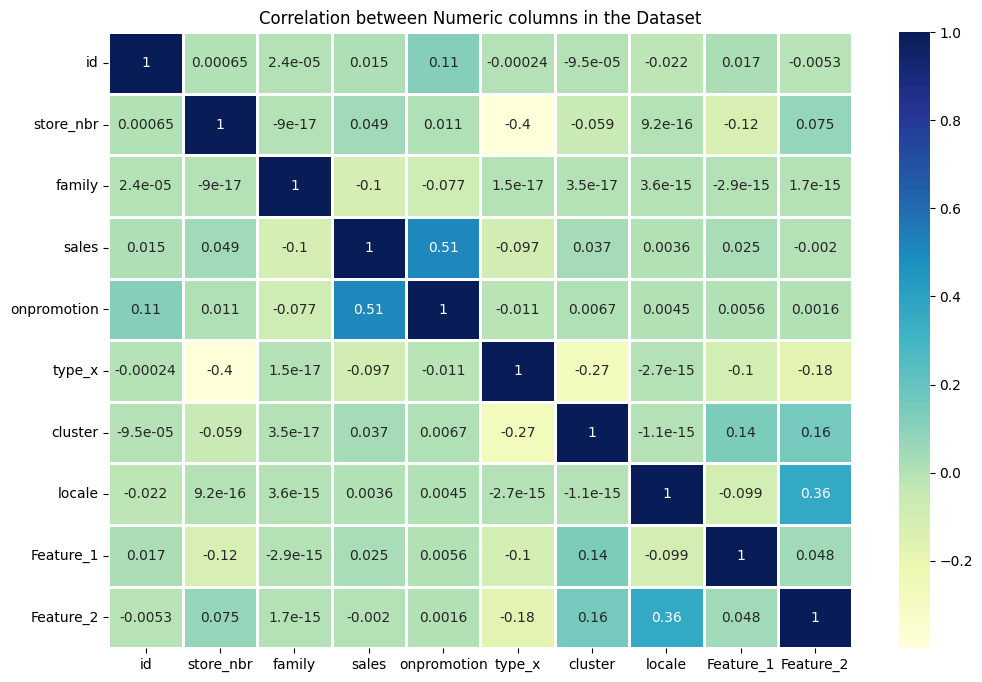

In [ ]:
import seaborn as sns
numeric_columns = df_train.select_dtypes(include=['float64','int64'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, cmap="YlGnBu", annot=True, linewidths=1.0)
plt.title("Correlation between Numeric columns in the Dataset")
plt.show()


In [ ]:
columns_to_drop = list(df_objects.columns) + ['id']
df_train = df_train.drop(columns_to_drop, axis=1)

In [ ]:
df_train

,store_nbr,family,sales,onpromotion,type_x,cluster,date,locale,Feature_1,Feature_2
0,1,1,5.000,0,4,13,2015-07-01,0,0.0,-2.0
1,1,2,0.000,0,4,13,2015-07-01,0,0.0,-2.0
2,1,3,5.000,1,4,13,2015-07-01,0,0.0,-2.0
3,1,4,2638.000,2,4,13,2015-07-01,0,0.0,-2.0
4,1,5,0.000,0,4,13,2015-07-01,0,0.0,-2.0
...,...,...,...,...,...,...,...,...,...,...
1381045,9,29,438.133,0,2,6,2017-08-15,3,-1.0,-1.0
1381046,9,30,154.553,1,2,6,2017-08-15,3,-1.0,-1.0
1381047,9,31,2419.729,148,2,6,2017-08-15,3,-1.0,-1.0
1381048,9,32,121.000,8,2,6,2017-08-15,3,-1.0,-1.0


In [ ]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.set_index(df_train['date'])
df_train = df_train.drop(['date'],axis=1)

In [ ]:
df_merge['date'] = pd.to_datetime(df_merge['date'])

# Tanggal yang ingin Anda akses
date_to_retrieve = pd.Timestamp('2015-07-01')

# Cari baris dengan tanggal yang sesuai dalam kolom 'date'
row_data = df_merge[df_merge['date'] == date_to_retrieve]

row_data

,id,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,date,type_y,locale,locale_name
0,1619838,1,1,5.00000,0,Quito,Pichincha,4,13,2015-07-01,0,0,0
1,1619839,1,2,0.00000,0,Quito,Pichincha,4,13,2015-07-01,0,0,0
2,1619840,1,3,5.00000,1,Quito,Pichincha,4,13,2015-07-01,0,0,0
3,1619841,1,4,2638.00000,2,Quito,Pichincha,4,13,2015-07-01,0,0,0
4,1619842,1,5,0.00000,0,Quito,Pichincha,4,13,2015-07-01,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1777,1621615,9,29,502.22202,0,Quito,Pichincha,2,6,2015-07-01,0,0,0
1778,1621616,9,30,84.58600,10,Quito,Pichincha,2,6,2015-07-01,0,0,0
1779,1621617,9,31,1608.97800,0,Quito,Pichincha,2,6,2015-07-01,0,0,0
1780,1621618,9,32,3.00000,0,Quito,Pichincha,2,6,2015-07-01,0,0,0


In [ ]:
def create_lag(df, lag_days, lag_dayss, target_col='sales', group_col='family'):
    df = df.copy()

    # Loop untuk lag_days
    for lag in lag_days:
        df[f'{target_col}_lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)

    # Loop untuk lag_dayss
    for lag in lag_dayss:
        df[f'{target_col}_lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)

    return df

# Membuat lag untuk setiap kategori family
df_train = create_lag(df_train, lag_days=[54*16], lag_dayss=[54*17])

In [ ]:
df_train.head(1783*2)

,store_nbr,family,sales,onpromotion,type_x,cluster,locale,Feature_1,Feature_2,sales_lag_864,sales_lag_918
date,,,,,,,,,,,
2015-07-01,1,1,5.00,0,4,13,0,0.0,-2.0,NaN,NaN
2015-07-01,1,2,0.00,0,4,13,0,0.0,-2.0,NaN,NaN
2015-07-01,1,3,5.00,1,4,13,0,0.0,-2.0,NaN,NaN
2015-07-01,1,4,2638.00,2,4,13,0,0.0,-2.0,NaN,NaN
2015-07-01,1,5,0.00,0,4,13,0,0.0,-2.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2015-07-02,9,31,1701.65,0,2,6,0,0.0,-2.0,NaN,NaN
2015-07-02,9,32,1.00,0,2,6,0,0.0,-2.0,NaN,NaN
2015-07-02,9,33,12.00,0,2,6,0,0.0,-2.0,NaN,NaN


In [ ]:
df_train.dropna(inplace=True)

In [ ]:
df_train.isnull().sum()

store_nbr        0
family           0
sales            0
onpromotion      0
type_x           0
cluster          0
locale           0
Feature_1        0
Feature_2        0
sales_lag_864    0
sales_lag_918    0
dtype: int64

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Train-test split
X = df_train.drop(['sales'],axis=1)
y = df_train['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit XGBoost model
model = xgb.XGBRegressor()

In [ ]:
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

In [ ]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE
mse = mean_squared_error(y_test, y_pred )
mae = mean_absolute_error(y_test, y_pred )

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 177405.8367847655
Mean Absolute Error (MAE): 117.41659180229276


In [ ]:
df_train

,store_nbr,family,sales,onpromotion,type_x,cluster,locale,Feature_1,Feature_2,sales_lag_864,sales_lag_918
date,,,,,,,,,,,
2015-07-18,1,1,1.000,0,4,13,0,0.0,-2.0,3.000,5.000
2015-07-18,1,2,0.000,0,4,13,0,0.0,-2.0,0.000,0.000
2015-07-18,1,3,1.000,0,4,13,0,0.0,-2.0,5.000,5.000
2015-07-18,1,4,2019.000,3,4,13,0,0.0,-2.0,2259.000,2638.000
2015-07-18,1,5,0.000,0,4,13,0,0.0,-2.0,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,9,29,438.133,0,2,6,3,-1.0,-1.0,517.911,425.854
2017-08-15,9,30,154.553,1,2,6,3,-1.0,-1.0,145.490,152.591
2017-08-15,9,31,2419.729,148,2,6,3,-1.0,-1.0,1882.588,1740.157


In [ ]:
df_test= pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')

In [ ]:
df_test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [ ]:
df_merge_test = pd.merge(df_test, df_stores, on='store_nbr', how='left')
start_id = df_test.index[0]

In [ ]:
df_merge_test

,id,date,store_nbr,family,onpromotion,city,state,type,cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,Quito,Pichincha,B,6
28508,3029396,2017-08-31,9,PREPARED FOODS,0,Quito,Pichincha,B,6
28509,3029397,2017-08-31,9,PRODUCE,1,Quito,Pichincha,B,6
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,Quito,Pichincha,B,6


In [ ]:
df_merge_test['date'] = pd.to_datetime(df_merge_test['date'])

In [ ]:
start_date = '2017-08-15'
df_holiday = df_holiday[(df_holiday['date'] > start_date)]
df_merge_test= pd.merge(df_merge_test,df_holiday,on='date',how='left')

In [ ]:

df_merge_test

,id,date,store_nbr,family,onpromotion,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN
28508,3029396,2017-08-31,9,PREPARED FOODS,0,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN
28509,3029397,2017-08-31,9,PRODUCE,1,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_merge_test = df_merge_test.fillna(0)
df_merge_test = pipeline.fit_transform(df_merge_test)

/tmp/ipykernel_33/3809350240.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[self.type_column].fillna(0, inplace=True)
/tmp/ipykernel_33/3809350240.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

In [ ]:
df_objects_test = df_merge_test.select_dtypes(include=['object'])

In [ ]:
from sklearn.feature_extraction import FeatureHasher

hasher = FeatureHasher(n_features=2, input_type='string')
hashed_features = hasher.fit_transform(df_objects_test.values.astype(str))
hashed_df = pd.DataFrame(hashed_features.toarray(), columns=['Feature_1','Feature_2'])
print(hashed_df)



       Feature_1  Feature_2
0            0.0       -2.0
1            0.0       -2.0
2            0.0       -2.0
3            0.0       -2.0
4            0.0       -2.0
...          ...        ...
28507        0.0       -2.0
28508        0.0       -2.0
28509        0.0       -2.0
28510        0.0       -2.0
28511        0.0       -2.0

[28512 rows x 2 columns]


In [ ]:
df_test = pd.merge(df_merge_test, hashed_df, left_index=True, right_index=True)

In [ ]:
df_test

,id,date,store_nbr,family,onpromotion,city,state,type_x,cluster,type_y,locale,locale_name,Feature_1,Feature_2
0,3000888,2017-08-16,1,1,0,Quito,Pichincha,4,13,0,0,0,0.0,-2.0
1,3000889,2017-08-16,1,2,0,Quito,Pichincha,4,13,0,0,0,0.0,-2.0
2,3000890,2017-08-16,1,3,2,Quito,Pichincha,4,13,0,0,0,0.0,-2.0
3,3000891,2017-08-16,1,4,20,Quito,Pichincha,4,13,0,0,0,0.0,-2.0
4,3000892,2017-08-16,1,5,0,Quito,Pichincha,4,13,0,0,0,0.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,29,1,Quito,Pichincha,2,6,0,0,0,0.0,-2.0
28508,3029396,2017-08-31,9,30,0,Quito,Pichincha,2,6,0,0,0,0.0,-2.0
28509,3029397,2017-08-31,9,31,1,Quito,Pichincha,2,6,0,0,0,0.0,-2.0
28510,3029398,2017-08-31,9,32,9,Quito,Pichincha,2,6,0,0,0,0.0,-2.0


In [ ]:
start_id = 3000888

In [ ]:
columns_to_drop = list(df_objects_test.columns) + ['id']
df_test = df_test.drop(columns_to_drop, axis=1)

In [ ]:
df_test

,date,store_nbr,family,onpromotion,type_x,cluster,locale,Feature_1,Feature_2
0,2017-08-16,1,1,0,4,13,0,0.0,-2.0
1,2017-08-16,1,2,0,4,13,0,0.0,-2.0
2,2017-08-16,1,3,2,4,13,0,0.0,-2.0
3,2017-08-16,1,4,20,4,13,0,0.0,-2.0
4,2017-08-16,1,5,0,4,13,0,0.0,-2.0
...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,9,29,1,2,6,0,0.0,-2.0
28508,2017-08-31,9,30,0,2,6,0,0.0,-2.0
28509,2017-08-31,9,31,1,2,6,0,0.0,-2.0
28510,2017-08-31,9,32,9,2,6,0,0.0,-2.0


In [ ]:
df_test

,date,store_nbr,family,onpromotion,type_x,cluster,locale,Feature_1,Feature_2
0,2017-08-16,1,1,0,4,13,0,0.0,-2.0
1,2017-08-16,1,2,0,4,13,0,0.0,-2.0
2,2017-08-16,1,3,2,4,13,0,0.0,-2.0
3,2017-08-16,1,4,20,4,13,0,0.0,-2.0
4,2017-08-16,1,5,0,4,13,0,0.0,-2.0
...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,9,29,1,2,6,0,0.0,-2.0
28508,2017-08-31,9,30,0,2,6,0,0.0,-2.0
28509,2017-08-31,9,31,1,2,6,0,0.0,-2.0
28510,2017-08-31,9,32,9,2,6,0,0.0,-2.0


In [ ]:
df_merge_test['date'] = pd.to_datetime(df_merge_test['date'])

# Tanggal yang ingin Anda akses
date_to_retrieve = pd.Timestamp('2017-08-16')

# Cari baris dengan tanggal yang sesuai dalam kolom 'date'
row_data = df_merge_test[df_merge_test['date'] == date_to_retrieve]

print(row_data)
print((row_data['family'] == 1).sum())

           id       date  store_nbr  family  onpromotion   city      state  \
0     3000888 2017-08-16          1       1            0  Quito  Pichincha   
1     3000889 2017-08-16          1       2            0  Quito  Pichincha   
2     3000890 2017-08-16          1       3            2  Quito  Pichincha   
3     3000891 2017-08-16          1       4           20  Quito  Pichincha   
4     3000892 2017-08-16          1       5            0  Quito  Pichincha   
...       ...        ...        ...     ...          ...    ...        ...   
1777  3002665 2017-08-16          9      29            0  Quito  Pichincha   
1778  3002666 2017-08-16          9      30            1  Quito  Pichincha   
1779  3002667 2017-08-16          9      31          158  Quito  Pichincha   
1780  3002668 2017-08-16          9      32           14  Quito  Pichincha   
1781  3002669 2017-08-16          9      33            0  Quito  Pichincha   

      type_x  cluster type_y  locale locale_name  
0          4

In [ ]:
df_test.reset_index(inplace=True)

In [ ]:
df_test

,index,date,store_nbr,family,onpromotion,type_x,cluster,locale,Feature_1,Feature_2
0,0,2017-08-16,1,1,0,4,13,0,0.0,-2.0
1,1,2017-08-16,1,2,0,4,13,0,0.0,-2.0
2,2,2017-08-16,1,3,2,4,13,0,0.0,-2.0
3,3,2017-08-16,1,4,20,4,13,0,0.0,-2.0
4,4,2017-08-16,1,5,0,4,13,0,0.0,-2.0
...,...,...,...,...,...,...,...,...,...,...
28507,28507,2017-08-31,9,29,1,2,6,0,0.0,-2.0
28508,28508,2017-08-31,9,30,0,2,6,0,0.0,-2.0
28509,28509,2017-08-31,9,31,1,2,6,0,0.0,-2.0
28510,28510,2017-08-31,9,32,9,2,6,0,0.0,-2.0


In [ ]:
start_date_1 = '2017-07-31'
end_date_1 = '2017-08-16'
sales_data_1 = df_train.loc[start_date_1:end_date_1, 'sales']

sales_data_1=sales_data_1.reset_index()
sales_data_1=sales_data_1.drop(['date'],axis=1)
# Memasukkan data sales ke df_test sebagai kolom sales_lag_864
df_test['sales_lag_864'] = sales_data_1

# Mengambil data sales dari df_train dari tanggal 2017-07-15 hingga 2017-08-01
start_date_2 = '2017-07-15'
end_date_2 = '2017-08-01'
sales_data_2 = df_train.loc[start_date_2:end_date_2, 'sales']
sales_data_2=sales_data_2.reset_index()
sales_data_2=sales_data_2.drop(['date'],axis=1)
# Memasukkan data sales ke df_test sebagai kolom sales_lag_918
df_test['sales_lag_918'] = sales_data_2

In [ ]:
df_test

,index,store_nbr,family,onpromotion,type_x,cluster,locale,Feature_1,Feature_2,sales_lag_864,sales_lag_918
date,,,,,,,,,,,
2017-08-16,0,1,1,0,4,13,0,0.0,-2.0,8.000,6.000
2017-08-16,1,1,2,0,4,13,0,0.0,-2.0,0.000,0.000
2017-08-16,2,1,3,2,4,13,0,0.0,-2.0,3.000,5.000
2017-08-16,3,1,4,20,4,13,0,0.0,-2.0,2414.000,2183.000
2017-08-16,4,1,5,0,4,13,0,0.0,-2.0,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,28507,9,29,1,2,6,0,0.0,-2.0,438.133,517.911
2017-08-31,28508,9,30,0,2,6,0,0.0,-2.0,154.553,145.490
2017-08-31,28509,9,31,1,2,6,0,0.0,-2.0,2419.729,1882.588


In [ ]:
df_test= df_test.set_index('date')

In [ ]:
df_test.drop(['index'],axis=1,inplace=True)

In [ ]:
predicts = model.predict(df_test)
df_test

,store_nbr,family,onpromotion,type_x,cluster,locale,Feature_1,Feature_2,sales_lag_864,sales_lag_918
3000888,1,1,0,4,13,0,0.0,-2.0,8.000,6.000
3000889,1,2,0,4,13,0,0.0,-2.0,0.000,0.000
3000890,1,3,2,4,13,0,0.0,-2.0,3.000,5.000
3000891,1,4,20,4,13,0,0.0,-2.0,2414.000,2183.000
3000892,1,5,0,4,13,0,0.0,-2.0,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...
3029395,9,29,1,2,6,0,0.0,-2.0,438.133,517.911
3029396,9,30,0,2,6,0,0.0,-2.0,154.553,145.490
3029397,9,31,1,2,6,0,0.0,-2.0,2419.729,1882.588
3029398,9,32,9,2,6,0,0.0,-2.0,121.000,41.000


In [ ]:
df_test.reset_index(drop=True, inplace=True)
df_test.index = df_test.index + 3000888 # Buat DataFrame baru untuk hasil prediksi
predictions_df = pd.DataFrame({
    'Id': df_test.index,  # Ambil PassengerId dari data uji
    'sales': predicts  # Masukkan hasil prediksi
})

# Simpan DataFrame ke dalam file CSV
predictions_df.to_csv('/kaggle/working/predictions.csv', index=False)

In [ ]:
predictions_df

,Id,sales
0,3000888,6.083122
1,3000889,1.426517
2,3000890,1.865026
3,3000891,1862.951172
4,3000892,-3.056057
...,...,...
28507,3029395,462.198303
28508,3029396,181.548935
28509,3029397,2158.142334
28510,3029398,67.735962
